# Python notebook for case-study run on the CICIDS security dataset, by William Bridges (part of BSc dissertation work)

## Code set-up: Imports, Packages, Environment variables, and Methods

The software versions used are:
- The Python3 version used for this work is: Python 3.8.x
- The scikit-learn version used is: scikit-learn 0.24.0
- The seaborn version used is: 0.11.1
- The Pandas version used is: 1.1.5 (although 1.2.0 was released recently, this should also work)

Before running, please run these commands via pip, in the terminal:
- pip install pandas
- pip install scikit-learn
- pip install scikit-plot
- pip install seaborn

## Imports

In [1]:
%matplotlib inline
import os, sys # For accessing Python Modules in the System Path (for accessing the Statistical Measures modules)
# See: https://stackoverflow.com/a/39311677
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
import scikitplot # Confusion matrix plotting
from sklearn.decomposition import PCA # For PCA dimensionality reduction technique
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application
from sklearn.preprocessing import LabelBinarizer # For converting categorical data into numeric, for modeling stage
from sklearn.model_selection import StratifiedKFold # For optimal train_test splitting, for model input data
from sklearn.model_selection import train_test_split # For basic dataset splitting
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors ML classifier (default n. of neighbors = 5)
from scikitplot.metrics import plot_confusion_matrix # For plotting confusion matrices
from sklearn.metrics import accuracy_score # For getting the accuracy of a model's predictions
from sklearn.metrics import classification_report # Various metrics for model performance
from sklearn.neural_network import MLPClassifier # For Neural Network classifier
from sklearn.linear_model import LogisticRegression

## Methods

Documentation for each method lives a cell above the method code. Method code is described and explained like this, and **all methods live in this section**.

**Clean_dataset()** method is used to remove infinite and Nan value errors (in the original dataset), which can cause issues in the PCA transform step.

- **assert** keyword can be used for testing purposes. If the input param is not of type Pandas Dataframe, then the error message will be shown. Thus, you 'assert' that a pd.Dataframe is input.


- **.dropna(inplace=True)** drops any rows which contain NaN/ Null values. NaN values would cause issues later on, with model training and other functions. A lot of functions require NaN values to be removed to work (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

Code reference: https://stackoverflow.com/a/46581125 (with a minor change = removed the conversion to float64 type)

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

**get_PCA_feature_names()** method is used to generate feature names for the number of PCA components passed in as a param. Returns a list of feature names for principal component column headings, in a Pandas Dataframe.

- No special code here, just pure Python code. Instantiating a list, and populating it with strings for the PCA header names. Then, appending each to the list and returning it.

In [3]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

**train_model_predict()** method is used to train an input model, using StratifiedFKold for train_test splitting, and uses the trained model to predict the test data. It outputs a classification report which has various useful prediction metrics displayed. It also outputs a confusion matrix for the model's predictions. Finally, it returns the accuracy of the model's predictions.

- 1) The for loop ('for train_index, test_index in skf.split(X, y):') is required as it uses the indexes that the  StratifiedKFold model (**skf**) produces to select the appropriate data rows/ points required for each data split.


- 2) The 'X_train, X_test = X.iloc[train_index], X.iloc[test_index]' uses the skf indexes to find the index location (iloc) of each index, so it can extract the correct rows for the train_test split.


- 3) The 'reshaped_y_train = np.asarray(y_train).reshape(-1, 1)' is required to reshape the label (y_train and y_test) to a 1D array, rather than a 2D array that is output by the train_test split.


- 4) The 'model.fit(X_train, reshaped_y_train.ravel())' uses the input model and fits it (trains the model) on the training data. The '.ravel()' method just reshapes the label array again (flattens it) to match the input structure required by the sklearn method.


- 5) The 'pred_y = model.predict(X_test)' uses the, now trained, model to attempt to predict the test data (X_test is passed in, and it predicts the label, pred_y).


- 6) The 'score = classification_report(reshaped_y_test, pred_y)' calculates prediction metrics based upon the model's predictions. More info in the docs: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

The rest is self-explanatory. A confusion matrix is plotted and output after the method runs. The accuracy of the model is returned back to the caller, as well as other data required for the statistical distance measure methods.

In [4]:
# See documentation above to understand what each step does, and why.
def train_model_predict(model, model_name, X, y, skf):
    for train_index, test_index in skf.split(X, y): # 1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # 2)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reshaped_y_train = np.asarray(y_train).reshape(-1, 1) # 3)
        reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    model.fit(X_train, reshaped_y_train.ravel()) # 4)
    pred_y = model.predict(X_test) # 5)
    score = classification_report(reshaped_y_test, pred_y) # 6)
    print('Classification report: \n', score, '\n')
    plot_confusion_matrix(reshaped_y_test, pred_y, title='Confusion Matrix for {}'.format(model_name))
        
    return accuracy_score(reshaped_y_test, pred_y), X_train, X_test, y_train, pred_y

**get_shuffled_stratifiedKFold_train_test_split()** method is for retrieving shuffled, StratifiedKFold train test split data. It's similar to the 'train_model_predict()' method above- see this for details behind each step/ line of code. This is industry-standard for dealing with datasets which have a large class imbalance, such as this one.

The method takes in X (dataset without the labels/ classes) and y (the label/ class feature). It instantiates a new StratifiedKFold 'model' which comes from the 'sklearn.model_selection' library. The **n_splits** parameter denotes how many folds (K) are to be run. The **Shuffle** parameter denotes that each split will be shuffled and therefore randomized to get varying shuffles between runs. This is ideal, as each permutation to be run should be as varied as possible to give good variance in plotting- so the SafeML idea can be showcased & plotted optimally.

The for loop uses the StratifiedKFold 'model' to extract indices that have been found by the skf model. The label/ class feature needs to be reshaped in SkLearn, as un-shaped label data causes exceptions/ errors when attempting to train, predict, or use any SkLearn ML classifiers/ models.

Finally, all the extracted data is returned.

See docs here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [5]:
def get_shuffled_stratifiedKFold_train_test_split(X, y):
    # Shuffle to True, to get different shuffles each time. Permutations being varied is the goal here.
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # For loop to get index for training and test data, using StratifiedKFold (3 splits)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # NOTE: Sometimes 'reshape' needed for label, so that the model can use it (required in SciKit)
        #reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
        #reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    # After for loop ends, all training and test data has been retrieved thus can return it.
    return X_train, X_test, y_train, y_test

### Neural Networks (MLP), quick explanation/ clarification (for below method's code explanation)

Neural Networks, and specifically the sklearn Multi-Layer Perceptron (MLPClassifier), aim to model the brain's neurons and its inner workings. 

A set of input values and weights are evaluated, and passed into the first layer of the neural network. The neural network can have multiple layers, with a varied amount of nodes (via hyperparameters) in each layer. 

Hyperparameters are the parameters of the model that- if changed- affect the learning rate and prediction accuracy.

If an input weight, X, along with a learning rate, Y, evaluates to a value above a given **threshold** (like a neuron's Potassium & Sodium based Action Potential threshold), then just like a real neuron, the neuron will fire and send information to the next node in the layer, or possibly the output node. 

The output node will take all of the processed information, from all the nodes in each interconnected (fully-connected MLP) layer, and a classification result will be given.

The inner workings of large Neural Nets are still un-explainable (as of March 2021), which is why they're referred to as a **Black-box classifier/ model**.

This is how a Neural Network learns and predicts a label/ class based on input data. The methods by which learning occurs (Backpropagation, Momentum, Learning rate input, Weight adjustments, etc...) is beyond the scope of this solution.

From docs: "Multi-layer Perceptron classifier. This model optimizes the log-loss function using LBFGS or stochastic gradient descent".

Important note from the default MLP params, from the docs: 
- "Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better". 

###### So the 'lbfgs solver' hyperparameter may not be ideal for this larger dataset. Thus, the 'Adam solver' will be used. 

(Code references: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

#### Finding the optimal Neural Network hyperparameters is hard
"So what about size of the hidden layer(s)--how many neurons? There are some empirically-derived rules-of-thumb, of these, the most commonly relied on is 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers" by Jeff Heaton (https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw). As per the reference, a low amount of nodes in the hidden layer can be ideal for a particular dataset. 

If the Input size is around 20 PCA component features, with 1 output node (for the label), then between 10 and 15 nodes, with 1 hidden layer, would be following these heuristics. It can be incredibly hard to train larger Neural Network correctly, although it has been proved- theoretically- that a Neural Network can solve any task, as long as it's large enough and has the correct hyperparameter tuning. This is an NP-hard problems though.

See docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

**train_and_predict_Neural_Network_MLP_model()** method trains a Neural Network (MLP) classifier and uses this to predict the labels of the X_test data. See more in-depth information about Neural Networks above^^^. For in-depth info on the hyperparameter tuning in SciKit (will be similar to TensorFlow & Keras, PyTorch, FastAI, and any other ML library), see below... (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

**Hyperparameter explanations:**
- **activiation=** ReLu is an industry-standard activation function "rectified linear unit function, f(x) = max(0, x)" (SciKit docs).
- **hidden_layer_sizes=** (x,) means 1 hidden layer with x nodes in. Each comma added defines a new hidden layer.
- **solver=** Adam solver works efficiently on large datasets, and is the "stochastic gradient-based optimizer" (SciKit docs).
- **alpha=** is a penalty (regularization term) parameter.
- **batch_size=** refers to the size of mini-batches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples).
- **learning_rate=** is the "learning rate schedule for weight updates". Setting as 'constant' would keep the learning rate the same as the learning_rate_init value, even if two epochs were to not decrease by at least 'tol', which is not ideal. Thus, an 'adaptive' learning rate is used and this "keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5" (SciKit docs).
- **learning_rate_init=** is just the initial learning rate value. It "controls the step-size in updating the weights".
- **max_iter=** refers to the maximum number of iterations the MLP classifier will run through (each iteration/ epoch updates the node weights in accordance to other hyperparam info e.g. activation function, alpha, learning rate, etc... This is to try and increase the predictive capability of the MLP model). SciKit docs state "For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps". Although, the more iterations, the longer the training takes. After a certain threshold, more iterations will not improve the predictive capability of the MLP model.

Note: Could add if statement to print out confusion matrix x amount of times, during this method.

In [6]:
def train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test):
    # Instantiating new Neural Network classifier and setting Hyperparameters
    Neural_Net_model = MLPClassifier(hidden_layer_sizes=(10,), activation='relu',
                                    solver='adam', alpha=0.0001, batch_size='auto',
                                    learning_rate='adaptive', learning_rate_init=0.005,
                                    max_iter=400)
    
    # Fitting the model is synonymous to training the model. Need to call .ravel() to get array in correct format.
    Neural_Net_model.fit(X_train, y_train.ravel())
    
    # Using the model to predict the label/ classes, based upon X_test data only. This is the model's answers.
    pred_y = Neural_Net_model.predict(X_test) 
    
    # Returning model answers and the accuracy of the model i.e. how well it predicts the answers.
    return pred_y, accuracy_score(y_test, pred_y)

**get_statistical_dist_measures_for_class_result()** method is for calculating the ECDF-based statistical distance measures for the entire dataset. Currently, the Python implementations of the statistical dist measures are **Univariate** meaning that they require each feature to be passed in, 1 at a time (**as of 8th April 2021**). Thus, an empty numpy array is set-up, with the size matching the number of features. Each index holds the specific statistical distance measure result, for the ith feature/ column.

The accuracy parameter holds some model accuracy that is to be passed in, so the result dictionary can be correctly returned in the perfect format (for the results table).

The X_train_L and X_test_L parameters hold the X_train and X_test data (a Pandas Dataframe i.e. 2D array, like a results table) for the dataset used in this Jupyter Notebook. The '**_L**' stands for 'label' so essentially this holds the train and test data, for a specific label/ class, based upon a query.

This method calculates all the Univariate results, and then calculates the mean/ average of the entire numpy array. This essentially retrieves the correct distance/ value for the ECDF-based statistical distance measure, as the mean is the correct value that should be returned. The mean represents the distance for the entire dataset, for that specific label/ class.

Finally, it returns a Python dictionary which is used to efficiently create a Pandas Dataframe results table, for plotting of the results. It's just a more efficient way of appending dynamic results to a Pandas Dataframe object. See the links and documentation for the code, where this method is called from, for more info.

See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.

In [7]:
# send to top and add documentation
def get_statistical_dist_measures_for_class_result(accuracy, X_train_L, X_test_L):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = len(X_train_L.columns)
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        # iloc[:, i] allows selection of the ith feature in the Pandas dataframe
        # Calling the methods from the imported Python modules (see import section at top of notebook)
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        
    # Computing mean/ average, to get ECDF distance of full dataset. Float64 to keep accuracy high.
    # See: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    CVM_distance = np.mean(CVM_distances, dtype=np.float64)
    Anderson_Darling_distance = np.mean(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_distance = np.mean(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_distance = np.mean(Kuiper_distances, dtype=np.float64)
    Wasserstein_distance = np.mean(Wasserstein_distances, dtype=np.float64)
    DTS_distance = np.mean(DTS_distances, dtype=np.float64)
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Accuracy': accuracy,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

**get_X_train_and_test_data_for_given_label()** method is used to get the X_train and X_test data rows that match the desired class/ label input, in the parameter. 

The **labels** parameter holds a numeric array, representing the number of classes/ labels in the y_train and y_test variables e.g. labels = [0, 1], which denotes that there are 2 classes/ labels in the incoming y_train and test parameters.

The **label_index** parameter holds the specific index for the **labels** array, to denote which specific class/ label is to be used e.g. label_index = 0, which denotes that label/ class 0 is the one to be queried for in the X_train and X_test data.

The **pred_y** parameter holds the model's predictions for which class a row should be (from fitting and predicting, using a model). This is used to query the X_test data to figure out how different the X_test and pred_y is from each other- as this is essentially what is needed for calculating the ECDF-based statistical distance measures for a class.

The other params **X_train, X_test, y_train, y_test** are just the dataset split done, for a model to trained. These are just passed in so that the required info can be extracted into the returned values. See this for an example of how these might be made: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

The results returned are used and sent to the ECDF-based statistical distance measure methods, which use them to calculate the statistical distance of the specific class/ label.

**DataFrame.loc[]** can be used to get the indexes/ rows which match the query inside the square brackets. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html

In [8]:
def get_X_train_and_test_data_for_given_label(labels, label_index, pred_y, X_train, X_test, y_train, y_test):
    X_train_loc_for_label = X_train.loc[y_train == labels[label_index]]
    X_test_loc_for_label = X_test.loc[pred_y == labels[label_index]]
    
    return X_train_loc_for_label, X_test_loc_for_label

**get_concatenated_results_holding_all_classes_results()** method is used to get a Pandas Dataframe object, that has a new column added (called 'dataset') which can differentate rows/ data points based upon the class. **It allows for dynamic returning of a results table, for the number of classes in the current dataset**.

The **result_dataframes** parameter holds a list of lists, where each list is the results for a specific class e.g. result_dataframes[0] would be the results table for class 0, which is a Pandas Dataframe. So essentially, this holds a list of Pandas Dataframes.

A Python 3.6 concept called 'f-strings' is used to dynamically create the 'dataset' column's datapoint names, based upon the current class, using the for loop. See: https://www.journaldev.com/23642/python-concatenate-string-and-int

**dataframe.append()** just appends something to the dataframes Python list.

**result_dataframes[i].assign(dataset = class_name)** takes the Pandas Dataframe at the index i, and uses the .assign() method. See the .assign() method docs here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html. This essentially returns a new object with all the original columns, but in addition to new ones. The new column will have the name defined in the first index, i.e. **'dataset'**, and a row in this column is defined by the **class_name**.

**pd.concat()** takes a list of Pandas Dataframes or Series objects, and concatinates/ joins them together. See here: https://stackoverflow.com/a/51733133 for the reasoning behind why this is being done.

In [9]:
# Using f-strings: https://www.journaldev.com/23642/python-concatenate-string-and-int
def get_concatenated_results_holding_all_classes_results(number_of_classes, result_dataframes):
    # Empty list to dynamically hold the dataframes which have been assigned a new dataset column
    dataframes = []
    
    # For each class/ label
    for i in range(number_of_classes):
        class_name = f'class{i}'
        dataframes.append(result_dataframes[i].assign(dataset = class_name))
    
    concatenated = pd.concat(dataframes)
    
    return concatenated

## Useful environment variables

In [10]:
# 'Reduced dimensions' variable for altering the number of PCA principal components. Can be altered for needs.
# Only 7 principal components needed when using non-normalised PCA dataset.
dimensions_num_for_PCA = 7

# Max number of permutations to run. Can be altered for needs.
number_of_permutations = 100

# 10 folds is usually the heuristic to follow for larger datasets of around this size.
num_of_splits_for_skf = 10

# Seed value to pass into models so that repeated runs result in the same output
seed_val = 1

# Number of statistical distance measures to run (for the results, columns section)
num_of_statistical_dist_measures = 6

# Code starting point

### Importing the dataset into Pandas.DataFrame and showing the top 5 entries via 'df.head()'

- **pd.read_csv()** reads in the csv dataset, which is in the **.gitignore file** as this shouldn't be included in the repo. Thus, to run, please put the same dataset into the same folder as this jupyter notebook file (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)


- The csv data is converted into a **Pandas Dataframe** object (via the pd.read_csv method). Pandas is really useful for data manipulation, and acts as a standardised way to work with data- allowing easier use of in-built functions without worrying about datatype coversion and compatability (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).


- The Pandas Dataframe consists of multiple **Pandas Series** objects, which are "One-dimensional ndarray with axis labels (including time series)". Thus, each Pandas Dataframe column/ feature/ attribute can be pulled out, and would then be a Pandas Series object (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)


- Finally, to note, **numpy** can also be used to manipulate the data where needed; if the functionality you're looking for is not in the Pandas library (e.g. specialised array-based manip functions). Numpy works nicely with Pandas (see docs: https://numpy.org/)


- **DataFrame.copy()** does a **deep copy** of the Dataframe, whereas **df_copy = df** would only do a **shallow copy**.


- **df.head()** just shows the top (5 by default) entries in the imported dataset, which is now of type Pandas.Dataframe (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)

In [11]:
# The .csv dataset file should be in the same project directory as this Jupyter Notebook file
Friday_Morning_Data = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df = Friday_Morning_Data.copy()
print("Datatype of Dataframe i.e. Pandas Dataframe: ", type(df))
print("Datatype of Column i.e. Pandas Series: ", type(df.iloc[:, 1]))
df.head()

Datatype of Dataframe i.e. Pandas Dataframe:  <class 'pandas.core.frame.DataFrame'>
Datatype of Column i.e. Pandas Series:  <class 'pandas.core.series.Series'>


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Data Preparation stage

See CRISP-DM for more information. Following industry-standard Data Science/ ML practises.

See: https://www.datascience-pm.com/crisp-dm-2/

### Fixing column name issues

Because of Excel being used to create the csv, the column headings/ names contain whitespace padding, incorrect capitalisation, etc... which makes it difficult to correctly select by column names. This piece of code below just removes these issues.

- **df_columns** can be used to access all the column heading names (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html)


- The code below acts on each of the header names (for ease of use): 
    - **str.strip()** just strips/ removes any leading and trailing spaces
    - **str.lower()** just converts all characters to lower case
    - **str.replace('x', 'y')** just replaces all instances of x with y, i.e. changing spaces to '_'
    - **str.replace('x', '')** can be used to remove the specified x characters (replacing with nothing/ empty char)

Code Reference: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

In [12]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

<ipython-input-12-6efba12d8d07>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Looking at the original data types
Self-explanatory. Just shows the data types of each feature/ column.

In [13]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

### Fixing issues with ScikitLearn's PCA transform on this dataset

Without cleaning the dataset, the PCA transform will throw this error: 
- "sklearn error ValueError: Input contains NaN, infinity or a value too large for dtype('float64')". 

It isn't obvious which attribute and/ or data points are causing this, as the input dataset is supposed to be fully clean with no Nan or erroneous values. Also, there are too many attributes to manually search through to check this too. Thus, a quick solution via stackoverflow was found to work (see the 'clean_dataset(df)' method at the top of the notebook).

Some rows have been removed by the cleaning, indicating that some rows did have issues/ errors within them.

In [14]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Resetting indexes since rows have been dropped. See the difference between above dataframe indexes and below.

- **.reset_index()** method resets the Pandas Dataframe indexes, for the rows. Useful to do after removing rows, as this messes up the indexes. It creates a new 'index' column that needs to be dropped, as it's useless (see docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)


- **.drop([column_name], axis=x, inplace=y)** drops a specified column from the dataframe and returns a new copy. When **inplace=True**, it transforms the Dataframe itself (instead of needing to copy). The **axis** specifies the dimension of what to drop i.e. if **axis=0, it drops a row**. If **axis=1, it drops a column**.

In [15]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286092,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286093,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286094,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Considerations before PCA can be used correctly (before Data Preparation feature selection via PCA)
Looking at this resource and many others (https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6), it can be seen that PCA can, quite easily, be used incorrectly without proper consideration and/ or understanding.

From the resource:
- "A common mistake new data scientists make is to apply PCA to non-continuous variables. While it is technically possible to use PCA on discrete variables, or categorical variables that have been one hot encoded variables, you should not. Simply put, if your variables don’t belong on a coordinate plane, then do not apply PCA to them"

Thus, PCA should **only** be applied to the numeric features- which should be scaled down to unit scale.

### What features should be included from PCA, and why?

Looking at the list of feature names in the dataset (shown below), one can see that all other features should be of numeric type (with domain knowledge). They're all currently numeric type (either float or int). Consequently, PCA **can be** fully applied.

- **df.columns.tolist()** converts the Dataframe column names into a Python list

In [16]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

### Data Preparation: PCA Dimension reduction and scaling (Hughes' Phenomenon)

PCA acts to reduce the dimensions/ search space of the dataset as much as possible, while trying to maintain the most information possible e.g. It can easily reduce the dimensionality by more than half, while still maintaining 99% of the original data's information- it does this by extracting out the most important information/ trends/ spread (variance) of each dimension/ attribute- into n 'principal components'.

More formally: PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.

##### *Key note:* 
"**PCA centers but does not scale the input data** for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for **Support Vector Machines with the RBF kernel** and the **K-Means clustering algorithm**." (https://scikit-learn.org/stable/modules/decomposition.html#pca)

PCA still works without standardizing the features to unit scale **but tranforming to unit scale should still be done** to prevent large variance features from having an over-bearing affect on other lower variance features (via something like StandardScaler here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

This is **particularly important with this dataset**, as some features have massively wide variances and others do not (e.g. the 'idle_std' values can range from e+06, all the way to zero).

- **Dataframe['x']** syntax allows the selection of one of the Dataframe columns (where 'x' is the column heading/ name).


- **df_Series.unique()** returns an array, showing all the unique values inside the Pandas Series object.

In [17]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
# Need to alter these to numeric 0, 1, etc... for model comprehension (e.g. pd.get_dummies()).
df_labels.unique()

array(['BENIGN', 'PortScan'], dtype=object)

The label column has to be removed as you don't want this involved in the PCA process. It can be concatted back with the PCA tranformed dataframe.

In [18]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0
286092,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,30,20,0.0,0.0,0,0,0.0,0.0,0,0
286093,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,47,20,0.0,0.0,0,0,0.0,0.0,0,0
286094,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0


### Using StandardScaler to transform features into unit scale (optional for PCA)
- **StandardScaler()** is an imported model from the sklearn.preprocessing library. It scales the specified Pandas Dataframe or Series object values to unit scale/ variance. This is usually required for certain functions to perform correctly, e.g. the PCA transform later (see docs: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


- StandardScaler().**fit_transform(df)** fits the StandardScaler model to the data, and transforms it into unit scale.


- **pd.Dataframe(data=x, columns=y)** can convert the data 'x' into a Pandas Dataframe object, using the respective columns 'y'

Code references: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [19]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.520898,-0.187809,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
1,-0.520898,-0.185393,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
2,-0.520898,-0.245528,-0.126811,-0.089163,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
3,-0.520898,-0.186116,1.921576,1.359240,1.336198,0.076910,1.143000,-0.427193,0.540263,0.729026,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
4,1.784164,-0.245532,-0.126811,-0.053837,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,-0.493464,-0.236595,2.331253,1.889143,0.587823,2.021738,1.490594,-0.427193,0.038237,0.711439,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286092,-0.493464,-0.228285,2.331253,1.959797,0.584609,1.993352,1.490594,-0.427193,0.036676,0.711676,...,1.896392,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286093,-0.493464,-0.238160,3.406657,3.514181,0.639251,4.179364,1.490594,-0.427193,-0.048179,0.563765,...,3.036806,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286094,-0.493464,-0.239023,2.382463,2.065778,0.587823,2.106896,1.490594,-0.427193,0.031310,0.702577,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561


### Plotting principle component variance

A scree plot displays the variance explained by each principal component within the analysis, of the **Normalised** dataset.

**The plot below shows that using the first 30 PCA components actually describes most/ all (99.9%) of the variation (information) within the Normalised dataset. This is a huge dimension reduction from the initial 78 features, down to just 30.**

Thus, looking at the Environment Variables (at the top of the notebook), the 'dimensions_num_for_PCA' variable will be set to between **10 and 25** based upon this evidence, to maximise efficiency and also dataset accuracy (after PCA).

(Code reference: https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465)

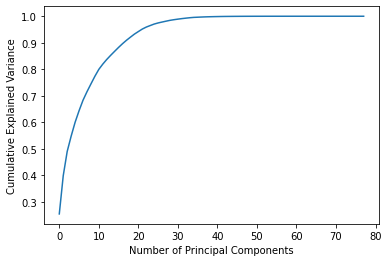

In [20]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

#### This Scree plot shows the variance explained by each principal component within the un-normalised dataset.

Therefore, using the un-normalised dataset for PCA, only around **5 to 7** principal components are needed to explain the entire (99.9...%) variation of the original dataset. This is a very large dimension reduction.

Thus, looking at the Environment Variables (at the top of the notebook), the 'dimensions_num_for_PCA' variable will be set to between **5 and 7** based upon this evidence, to maximise efficiency and also dataset accuracy (after PCA). If the non-normalised dataset is being used, of course.

(Code reference: https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465)

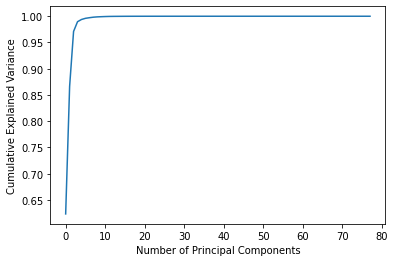

In [21]:
# The df_no_labels dataset holds the un-normalised dataset.
pca_test = PCA().fit(df_no_labels)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Important note on these above scree plot results ^

**The results of these graphs can change/ vary between different datasets used. Thus, these need to be inspected each time a new dataset (.csv file) is to be run on this code. Then, using the information the plots show, one should alter the environment variables, and thus the Neural Network/ MLP model's hyperparamters (tuning the Neural Network hyperparameters relies on knowing and using the number of features in a dataset).**

### Now fitting and transforming the data with PCA

Thus, the optimal number of principle components is set to the environment variable and this is now used to produce the appropriate multi-dimensional principle component array. This will be formatted back to a Pandas dataframe afterwards.

References: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html and https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [22]:
pca = PCA(n_components=dimensions_num_for_PCA)
#principal_components = pca.fit(df_scaled).transform(df_scaled) => for normalised PCA

# Non-normalised PCA
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-8.16580279e+06, -1.19915322e+06,  1.27263308e+05, ...,
         8.93600581e+05,  2.96811663e+05,  5.98234594e+03],
       [-8.08590567e+06, -1.19861324e+06,  9.21736216e+04, ...,
         8.99819189e+05,  2.96878115e+05,  5.81150453e+03],
       [-1.00194924e+07, -1.22629216e+06,  2.02487220e+05, ...,
        -2.15507753e+05, -5.82407941e+04, -3.75222176e+04],
       ...,
       [-9.77881129e+06,  1.20711384e+05,  1.08402286e+05, ...,
        -1.99889067e+05, -4.93926336e+04, -4.26804840e+04],
       [-9.80388112e+06, -4.42548507e+05,  1.21580327e+05, ...,
        -1.96639141e+05, -4.85337246e+04, -3.96503044e+04],
       [-9.72175186e+06, -6.79955648e+05,  1.08244069e+05, ...,
        -1.93449359e+05, -3.30418761e+04, -3.68706087e+04]])

### Getting Principal Component feature names, dynamically

Getting the Principal Component feature names, dynamically, for the optimal number of components (passed in as a param). Allows dynamic changing of PCs used. 

i.e. **One can change the 'dimensions_num_for_PCA' environment variable, and all the code will still work.**

In [23]:
# See Methods at the top of the notebook
principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA)

Turning the Principal Components back into a Pandas Dataframe, ready for concatting back with the **label** feature.

In [24]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415
...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436


### Joining/ concatinating the label feature back onto the pca transformed dataset. 

Label still needs to be transformed into binary data (for model comprehension/ understanding i.e. the model doesn't understand string data but string data can be transformed into numeric data, which is model can understand and use).

See the Pandas.concat docs here: https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [25]:
df_final = pd.concat([df_pc, df_labels], axis = 1)
# Scroll to the RHS end of dataframe to see attached label feature
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,BENIGN
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,BENIGN
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,BENIGN
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,BENIGN
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,BENIGN
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,BENIGN
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,BENIGN
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,BENIGN
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,BENIGN


### Transforming the label feature's categorical data into numeric data (via LabelBinarizer)

Again, a model can't understand, for example, 'yes' and 'no' strings but... these can be mapped to a 1 for yes and a 0 for no. Then a model can understand, as it requires numeric input to distinguish the feature's domain of values.

The **sklearn.preprocessing.LabelBinarizer** can be used to convert the column data into binary numbers, which will then be correctly interpreted.

1. Fit the List- this tells the LabelBinarizer what values exist, and how to map them. 

2. Call transform, passing a List, and this will return the encoded List.

**(Note: if label column has more than 2 unique labels, pandas.get_dummies is required instead)**

(Code reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)

In [26]:
lb = LabelBinarizer()
df_final['label'] = lb.fit_transform(df_final['label'])
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,0
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,0
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,0
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,0
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,0
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,0
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,0
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,0
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,0


Showing the transformation. **Again, to note, if label isn't binary then pd.get_dummies is required.**

See pandas get_dummies docs here for more information: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [27]:
print("Before LabelBinarizer: ", df_labels.unique())
print("After LabelBinarizer: ", df_final['label'].unique())

Before LabelBinarizer:  ['BENIGN' 'PortScan']
After LabelBinarizer:  [0 1]


#### The data is now fully cleaned and transformed, ready for pre-modeling test_train data splitting

## K-Fold Cross Validation and Stratified splitting
K-Fold is a technique which splits data into K folds (splits). Train of a model K times, and for each training iteration, K-Fold selects a different fold to use for testing; the remaining K - 1 folds become the training data. Typically, the optimal K value can be derived using the size of your dataset (num of rows). Ideally, each fold should be statistically representative of the population. Too small and it won't be useful. Too large, and you lose the positives from doing K-Fold.

You can use Stratified splitting with K-Fold, which ensures balance between some criteria (balances out the classes) e.g. equal portion of label classes in each fold.

Class Imbalance is a significant issue in the ML/ Data Mining domain. It leads to incorrect results e.g. if one fold had all of 1 label (accidentally), then it would produce terrible predictive results as it wouldn't know what the other label class data point would look like. You can only work with the data you have, so this has to be dealt with.

Benefits of K-Fold:
- Use more of the data towards making a succesful model.
- Obtain K models to evaluate, can improve the confidence that you have selected an appropriate model algorithm and cleaned/ prepared the data correctly, e.g. normal split with 1 model, one doesn't know if it's good or not- it could be heavily biased. Multiple models ensures less bias and increased variance.
- Looking at the accuracy results from each of the k-Folds, you can identify data issues e.g. a certain fold performs really badly. Could this suggest that more cleaning is required? Maybe the data preparation was performed incorrectly?
- If all folds return similar accuracies, one can be more confident that a deployed model will perform similarly to how one expects.

Issues with K-Fold:
- Creating K separate models requires more computation.
- If you haven't got much data, you might not get many folds. Less folds means K-Fold loses its benefits.
- If K is very large, each fold is small, and harder to ensure statistical distribution of.
- Choosing the best of K models introduces bias. Real world data could perform better under a more general, lower performing model.

Code reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [28]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df_final.drop(['label'], axis = 1)
y = df_final['label']
y

0         0
1         0
2         0
3         0
4         0
         ..
286091    0
286092    0
286093    0
286094    0
286095    0
Name: label, Length: 286096, dtype: int64

Initialising the StratifiedKFold model (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

In [29]:
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

Now, splitting the data into train and test data, using the optimal splitting techniques of K-Fold and Stratified Splitting.

Code reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [30]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  257487
y_train length:  257487
X_test length:  28609
y_test length:  28609


# Modeling stage
Data is now fully transformed and ready for ML model training and predictions.

See CRISP-DM for more information. Following industry-standard Data Science/ ML practises.

See: https://www.datascience-pm.com/crisp-dm-2/

### K-Nearest neighbor ML classifier
The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are assumed to be near to each other.

The most important factor in training a KNN model is the **number of neighbors hyperparameter**. You want to choose the K  value that reduces the number of errors, while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before. Here are some important considerations:

- As you decrease the value of K to **1**, predictions become less stable e.g. imagine K=1 and you have a query point surrounded by several red 'dots' and one green 'dot', but the green dot is the single nearest neighbor. Reasonably, you would think the query point is most likely red, but because K=1, KNN incorrectly predicts that the query point is green.

- Inversely, as you increase the value of K, predictions become more stable due to majority voting/ averaging, and thus, more likely to make more accurate predictions (up to a certain critical point- an **'overfitting' threshold**). Eventually, you would begin to witness an increasing number of errors. It is at this point you'd know that you have pushed the value of K too far.

- In cases where you are taking a majority vote (e.g. picking the mode in a classification problem) amongst labels/ classes, you usually make K an odd number to have a tiebreaker.

The sklearn's default k value is 5 (also true for MATLAB's implementation).

References: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html & https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

In [31]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                                    algorithm='auto', leaf_size=30,
                                    p=2, metric='minkowski',
                                    metric_params=None, n_jobs=None)

### Training the model and predicting test data results (confusion matrix)
The selected Machine Learning classifier/ model/ models can now be trained on training data (from the StratifiedKFold splitting). Once the model is trained, it can be used to predict the test data's labels (based upon what it has seen before).

The performance of the model can be seen below in the Classification Report, Confusion Matrix, and the model's predicitive accuracy result.

(see **methods** section, at the top of the notebook, for the train_model_predict() method code. Note that it can take a few minutes to run due to the vast amount of data used, and the training time required for the model to learn).

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12729
           1       1.00      1.00      1.00     15880

    accuracy                           1.00     28609
   macro avg       1.00      1.00      1.00     28609
weighted avg       1.00      1.00      1.00     28609
 

Model accuracy=  99.65395504911042 %

Dataset labels:  ['BENIGN' 'PortScan']
Dataset numeric labels after encoding for model:  [0 1]


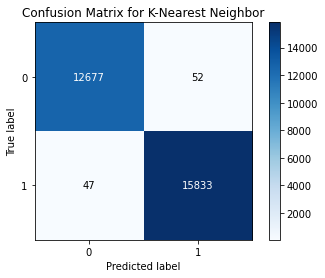

In [32]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(knn_model, "K-Nearest Neighbor", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

## The SafeML statistical distance measures: test/ example run
Now the ML models have been run, and the accuracy is found (along with other useful performance metrics), a test run of using the SafeML statistical distance measures can be run. This is a test run, and the real run will be done later. This test run is a guided 'tour' around how to set-up the code, in Python and SciKit-Learn, so that results can be re-produced easily for future case-studies or projects.

In [33]:
# Extracting the number of classes and labels from the label feature
class_num = len(df_final['label'].unique())
labels = df_final['label'].unique()
print("Number of classes: ", class_num)
print("Labels: ", labels)

Number of classes:  2
Labels:  [0 1]


In [34]:
X_train

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,1.272633e+05,2.315254e+05,893600.580534,2.968117e+05,5.982346e+03
1,-8.085906e+06,-1.198613e+06,9.217362e+04,2.225549e+05,899819.189254,2.968781e+05,5.811505e+03
2,-1.001949e+07,-1.226292e+06,2.024872e+05,-1.140260e+05,-215507.753418,-5.824079e+04,-3.752222e+04
3,-8.104574e+06,-1.198907e+06,1.145798e+05,2.320525e+05,886792.249240,3.093025e+05,6.391775e+03
4,-1.001953e+07,-1.226232e+06,2.024965e+05,-1.140800e+05,-215668.219754,-5.825571e+04,-3.761621e+04
...,...,...,...,...,...,...,...
264345,2.198678e+08,1.380216e+06,1.701027e+08,-5.037324e+07,351189.985289,-3.080752e+06,2.176100e+06
264346,-9.906154e+06,-1.223417e+06,2.222463e+05,-1.001826e+05,-118844.252902,-2.512903e+04,-1.045444e+02
264347,-9.974813e+06,-1.223502e+06,2.102830e+05,-1.085742e+05,-177375.336509,-4.516016e+04,-2.274868e+04
264348,-9.991084e+06,-1.218311e+06,2.086187e+05,-1.100024e+05,-191929.370539,-4.893430e+04,-3.011515e+04


Pre-finished code using just the first label in the labels array. Selects all the relevant rows/ data points. 

- **.loc[]** method can be used to locate certain rows based upon the query passed into the square brackets[].

In [35]:
# x1 = X_test[np.where(np.asarray(y_train).reshape(-1, 1).ravel() == labels[0])]
# X_train_L = X_train.iloc[np.where(y_train[:,1] == 1)]
X_train_L = X_train.loc[y_train == labels[0]]
X_train_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,1.272633e+05,2.315254e+05,893600.580534,2.968117e+05,5.982346e+03
1,-8.085906e+06,-1.198613e+06,9.217362e+04,2.225549e+05,899819.189254,2.968781e+05,5.811505e+03
2,-1.001949e+07,-1.226292e+06,2.024872e+05,-1.140260e+05,-215507.753418,-5.824079e+04,-3.752222e+04
3,-8.104574e+06,-1.198907e+06,1.145798e+05,2.320525e+05,886792.249240,3.093025e+05,6.391775e+03
4,-1.001953e+07,-1.226232e+06,2.024965e+05,-1.140800e+05,-215668.219754,-5.825571e+04,-3.761621e+04
...,...,...,...,...,...,...,...
264345,2.198678e+08,1.380216e+06,1.701027e+08,-5.037324e+07,351189.985289,-3.080752e+06,2.176100e+06
264346,-9.906154e+06,-1.223417e+06,2.222463e+05,-1.001826e+05,-118844.252902,-2.512903e+04,-1.045444e+02
264347,-9.974813e+06,-1.223502e+06,2.102830e+05,-1.085742e+05,-177375.336509,-4.516016e+04,-2.274868e+04
264348,-9.991084e+06,-1.218311e+06,2.086187e+05,-1.100024e+05,-191929.370539,-4.893430e+04,-3.011515e+04


Pre-finished code using just the first label in the labels array. Selects all the relevant rows/ data points based upon the query placed inside the square brackets.

In [36]:
X_test_L = X_test.loc[pred_y == labels[0]]
X_test_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
247042,-1.003719e+07,3.746366e+05,201535.291293,-113791.182822,-215671.736504,-58453.724072,-37876.926666
247162,-9.474344e+06,-1.171362e+06,290499.044682,-24916.077897,-159436.069748,202752.848791,89131.592084
247164,-1.007432e+07,4.610053e+06,193101.984439,-101728.148800,-209863.707542,-74877.503832,-47190.555650
248237,-9.271826e+06,-1.181135e+06,323589.702362,8387.451593,-138267.409296,300314.086017,136380.325307
248241,-1.007971e+07,4.969413e+06,194145.860996,-104411.735824,-210512.019112,-70642.129348,-44726.982493
...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436


### Running the Statistical distance measure algorithms
This is just a preliminary run to show an example of how to use the methods.

In [37]:
num_of_features = len(X_train_L.columns)
num_of_features

7

Running the statistical measure (univariate version) methods from the local Python modules defined in the project folder.

Because the Python methods are slightly different to the current MATLAB versions **(as of 8th March 2021)**, one has to pass in a feature 1 at a time (univariate). Then, after all the features have been passed in and sent back, this means the full dataset has been used to calculate the various ECDF-based statistical distance measures. This is what is displayed in the plotting of results section below.

In [38]:
CVM_distances = np.zeros(num_of_features)
Anderson_Darling_distances = np.zeros(num_of_features)
Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
Kuiper_distances = np.zeros(num_of_features)
Wasserstein_distances = np.zeros(num_of_features)
DTS_distances = np.zeros(num_of_features)

for i in range(0, num_of_features):
    # iloc[:, i] allows selection of the ith feature in the Pandas dataframe 
    CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    
print(" Cramer Von Mises distances: ", CVM_distances)
print("\n Anderson Darling distances: ", Anderson_Darling_distances)
print("\n Kolmogorov Smirnov distances: ", Kolmogorov_Smirnov_distances)
print("\n Kuiper distances: ", Kuiper_distances)
print("\n Wasserstein distances: ", Wasserstein_distances)
print("\n DTS distances: ", DTS_distances)

 Cramer Von Mises distances:  [2145.09062898 3554.18538115 2795.2436322  1583.62379235 1961.45443754
 4157.49306459 3448.61466525]

 Anderson Darling distances:  [15.67865018 23.73500686 18.74131197 11.34771928 12.67932826 26.91382278
 22.30160905]

 Kolmogorov Smirnov distances:  [0.03326813 0.06777357 0.04982426 0.03216095 0.03921818 0.06471298
 0.06118417]

 Kuiper distances:  [0.03328559 0.01342934 0.04984172 0.03217841 0.03923564 0.06473044
 0.06125403]

 Wasserstein distances:  [3632561.56936991  697564.99629972 1409309.94123758  503034.05463809
  196335.98494874  142255.88702355  100757.23898966]

 DTS distances:  [39541.56024532 41304.46940677 28045.40926569 12410.22839265
 10182.44208158  8299.55955336  8538.95643399]


### Plotting the test/ example results
This shows the varying distances of each statistical distance measure, between **each feature only**, in a single dataset split (1 permutation). Therefore, it is only an example and not representative of the real run (like a CRISP-DM cycle run through, where one can evaluate and re-run after).

The real run will plot the distances between all the features (entire dataset) of each dataset split (Permutation) against the average accuracy from all permutations. Thus, showing how statistical distances can be used to estimate the accuracy of models (the SafeML idea).

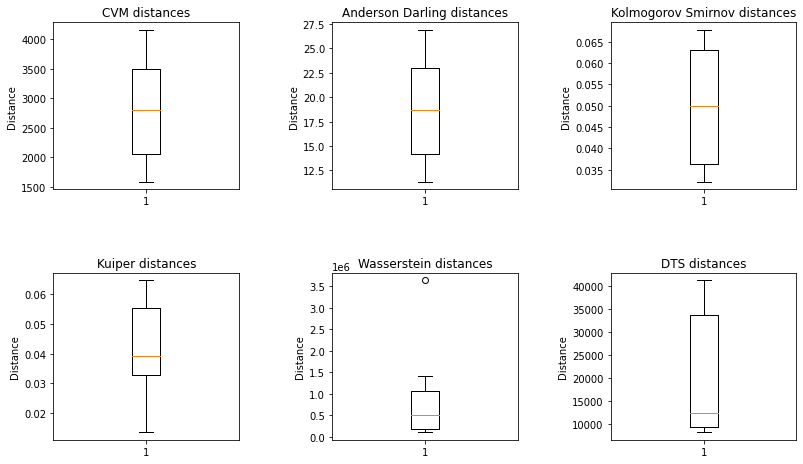

In [39]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].boxplot(CVM_distances)
axs[0, 0].set_title('CVM distances')
axs[0, 0].set_ylabel("Distance")

axs[0, 1].boxplot(Anderson_Darling_distances)
axs[0, 1].set_title('Anderson Darling distances')
axs[0, 1].set_ylabel("Distance")

axs[0, 2].boxplot(Kolmogorov_Smirnov_distances)
axs[0, 2].set_title('Kolmogorov Smirnov distances')
axs[0, 2].set_ylabel("Distance")

axs[1, 0].boxplot(Kuiper_distances)
axs[1, 0].set_title("Kuiper distances")
axs[1, 0].set_ylabel("Distance")

axs[1, 1].boxplot(Wasserstein_distances)
axs[1, 1].set_title("Wasserstein distances")
axs[1, 1].set_ylabel("Distance")

axs[1, 2].boxplot(DTS_distances)
axs[1, 2].set_title("DTS distances")
axs[1, 2].set_ylabel("Distance")

fig.subplots_adjust(left=0.08, right=1.8, bottom=0.05, top=1.5, hspace=0.5, wspace=0.5)

plt.show()

# Starting the real run, using the PCA-transformed dataset
The dataset shown below is the PCA-transformed data, with the label/ class feature attached (which has been LabelBinarized, into numbers from class names- so the model can understand).

To simulate the SafeML idea, a number of permutations have to be run. Each permutation will have its data split differently, and this results in varying model accuracies (different data => different accuracies). The hope (for the simulation) is that as these accuracies vary between permutations, the statistical difference values vary along with it- in a highly (positive) correlated way. 

This would show that ECDF-based statistical distance measures can actually be used to predict model performance. The final graphing/ plotting will show these relationships, so the correlation can be easily identified. A case-study for this dataset has been run in MATLAB, but not Python. 

The aim of this file is to have a Python code case-study for the same dataset, and verify the results to see if they match/ are similar to the MATLAB implementation. 

If it matches, then this case-study can be confidently merged into the master branch, of the SafeML repository.

In [40]:
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,0
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,0
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,0
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,0
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,0
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,0
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,0
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,0
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,0


## Starting the main loop and all other required loops (for permutations)
The permutation number is instantiated at the top of the notebook, in the environment variables section. This allows the number of permutations to be easily changed.

**IMPORTANT NOTE:** A **for loop** in one Jupyter Notebook cell cannot be extended past a single cell. This is bad for documentation purposes because markdown cells cannot be inserted between cells as this would cause the **for loop** to become out of scope for other cells. Therefore, a highly modulated approach must be taken, where everything is put into a function/ method. This allows markdown cells to exist above a section of code/ method so it can be explained/ documented. Code comments will be used when necessary too.

Instead of a 3D array (like the MATLAB implementation), this uses just 1 classifier at a time and uses Pandas DataFrames (2D array essentially) for easy plotting later, as one can use the Seaborn plotting library (https://seaborn.pydata.org/). Each Pandas Dataframe row is a permutation and each column has: the model's accuracy in 1st column, then each subsequent statistical distance measure to be used in the later columns.

Then, one can graph a line graph/ Seaborn 'relplot' (https://seaborn.pydata.org/api.html) of the accuracy on the x-axis vs the specific statistical distance measure on the y-axis. Therefore resulting in 6 plots/ graphs, 1 for each ECDF statistical distance measure.

Each class will represent a line on the graph (differentiated via hue colouring). Classes/ labels could also be separated by having separate plots for each class/ label. The hue approach is what has been used.

NOTE: Could also store F1-Score, Sensitivity score, Precision score, etc... to see how these relate to the ECDF statistical distance measures too.

In [41]:
# Firstly, creating the final 2D-array (Pandas Dataframe) which will be used to store the Results
# PRESERVE THE ORDERING
results_column_names = ['Accuracy', 'Anderson_Darling_dist', 'CVM_dist',
                                     'DTS_dist', 'Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist']
# Creating the empty Dataframe for Results
df_results = pd.DataFrame(columns = results_column_names)
# Can copy this dataframe for future results tables e.g. for each class/ label
df_results

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist


## Code for each permutation
Now, running the code for each permutation requires Stratified splitting (KFold optional), model training and predicting classes via the chosen classifier, and finally the iteration over each class/ label to calculate the statistical distance. Then, once complete, the results table can be used to plot the results from all the permutations.

**Quick note on terminology:** The terminology 'class' and 'label' is used interchangeably throughout the industry, but both mean the same things. They represent the different possible answers the dataset holds and/ or the model can output e.g. a dataset (for supervised learning i.e. given the answers to train with) with a person's personal data may have 2 classes/ labels (answers). Either Male or Female. Male is 1 class/ label, and Female is 1 class/ label. The number of classes in the dataset would be 2. Also, a model would only be able to predict and output 2 different options/ results.

Using Python 'List Comprehensions'. This way is Python sub-list ID safe, see link for more info: https://thispointer.com/how-to-create-and-initialize-a-list-of-lists-in-python/

See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.

**Most functionality has been extracted to functions/ methods, which reside at the top of this Jupyter Notebook file. Documentation and explanations behind each step can be found in the Methods section at the top of this Jupyter Notebook. There, it describes what each method does, what the parameters are for, and why the returned values are to be returned** 

In [42]:
# 1st Set all variables needed outside for loop scope, e.g. the multi-dimensional Results array.
labels = df_final['label'].unique()
number_of_classes = len(df_final['label'].unique())

# List of Lists to hold each separate label result, using list_index->label_number mapping (for accessing)
list_of_lists_results = [[] for i in range(number_of_classes)]

for current_permutation in range(number_of_permutations):
    # 1.1. Cross validation, train test stratified splitting (extracted to a function, see top of file)
    X_train, X_test, y_train, y_test = get_shuffled_stratifiedKFold_train_test_split(X, y)
    
    # 1.2. Train MLP (Neural net) model using the train test data, and model.predict to get pred_y
    pred_y, accuracy = train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test)
    
    # 1.3. loop over each label/ class
    for current_label in range(number_of_classes):
        
        # 1.4. Gets the correct indices for the train and test data ('X' data holds no labels)
        X_train_loc_for_label, X_test_loc_for_label = get_X_train_and_test_data_for_given_label(labels,
                                                        current_label, pred_y, X_train, X_test, y_train, y_test)
        
        # 1.5. Gets all ECDF statistical distance measures for current_label
        dict_result_row = get_statistical_dist_measures_for_class_result(accuracy,
                                                X_train_loc_for_label, X_test_loc_for_label)
        
        # 1.6. Append new dict row to current_label index of list of lists
        list_of_lists_results[current_label].append(dict_result_row)

After all permutations, convert each index (dict list) to a pandas dataframe. 

See this resource behind the idea. It's highly efficient but was more complicated to implement: www.stackoverflow.com/a/17496530

In [43]:
# Access specific dataframe by index e.g. class 1 dataframe->index 1 mapping
result_dataframes = []

for dict_result_list in list_of_lists_results:
    result_dataframes.append(pd.DataFrame(dict_result_list, columns = results_column_names))

Printing the result dataframes. The .head(x) method just shows the top x rows in the dataframe.

In [44]:
# Print first dataframe result table, for class 0
result_dataframes[0].head(8)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.796540,89.820418,12665.226010,76486.341126,0.273405,0.094457,4.307252e+06
1,0.631269,155.152898,18194.520990,312960.419108,0.449301,0.299115,1.956452e+07
2,0.823206,44.682184,7327.154336,20722.218251,0.142215,0.142231,1.062932e+06
3,0.795103,65.368891,10890.203068,25251.293763,0.212287,0.198014,1.459800e+06
4,0.632412,155.106535,18251.950052,322448.662902,0.449979,0.297204,1.933410e+07
5,0.926399,22.817250,3461.438782,13634.534827,0.068434,0.041007,7.008124e+05
6,0.630651,151.223163,17897.409804,350915.841629,0.436118,0.289647,1.918122e+07
7,0.916678,30.806826,4712.777394,16595.837967,0.087267,0.030923,9.887320e+05


In [45]:
# Print second dataframe result table, for class 1
result_dataframes[1].head(8)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.796540,62.862804,9058.514234,7653.356512,0.162611,0.046815,81181.933716
1,0.631269,106.052672,17094.990107,24011.766631,0.286008,0.074150,562656.498273
2,0.823206,37.609788,5283.767311,7330.647182,0.143470,0.100780,71327.564495
3,0.795103,73.798046,10907.282075,7730.200017,0.272046,0.094658,83909.720085
4,0.632412,105.658784,17024.021257,22935.411091,0.285001,0.073806,526640.920121
5,0.926399,16.053651,2086.241241,7982.194416,0.040850,0.011630,69748.639607
6,0.630651,104.678468,16831.752759,23051.927432,0.282249,0.073609,553849.582166
7,0.916678,18.117445,2513.394008,7715.143317,0.050837,0.017559,74206.704731


There's only 2 classes, so only 2 result dataframes are shown. Each row represents a permutation. Each dataset represent a single class.

## Plotting the results

Following: https://stackoverflow.com/a/51733133 to show both datasets in the same Seaborn graph. Seaborn doesn't allow multiple plots to be layered over each other, like in MatPlotLib, so you have to concatenate the results and use 'hue' on the new column, which represents each dataset.

First, one has to get all the data into 1 Dataframe. The number of classes in the current dataset is passed to the method below, which **dynamically** returns the concatenated Dataframe, holding the row information for all the classes, separated by a newly added column called **'dataset'**, which one can see below. Each class can be separated in this way.

This is really important, as the **Seaborn graphing/ plotting only works when 1 Dataframe is used**. It can't graph using multiple dataframes passed in, unlike MatPlotLib may be able to.

Now, in Seaborn graphing/ plotting, the **'hue'** parameter can be placed upon the **'dataset'**, which allows the plots to differentiate between classes visually, by using a different colour or pattern for each class. If a dataset holds more than 7 or 8 different classes, this may cause the plotting to look too cluttered and separate plotting may be required. **For this dataset, and others in the Network Intrusion CICIDS2017_Security_dataset, it works well.**

In [46]:
concatenated = get_concatenated_results_holding_all_classes_results(number_of_classes, result_dataframes)
concatenated.head(110)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,dataset
0,0.796540,89.820418,12665.226010,76486.341126,0.273405,0.094457,4.307252e+06,class0
1,0.631269,155.152898,18194.520990,312960.419108,0.449301,0.299115,1.956452e+07,class0
2,0.823206,44.682184,7327.154336,20722.218251,0.142215,0.142231,1.062932e+06,class0
3,0.795103,65.368891,10890.203068,25251.293763,0.212287,0.198014,1.459800e+06,class0
4,0.632412,155.106535,18251.950052,322448.662902,0.449979,0.297204,1.933410e+07,class0
...,...,...,...,...,...,...,...,...
5,0.926399,16.053651,2086.241241,7982.194416,0.040850,0.011630,6.974864e+04,class1
6,0.630651,104.678468,16831.752759,23051.927432,0.282249,0.073609,5.538496e+05,class1
7,0.916678,18.117445,2513.394008,7715.143317,0.050837,0.017559,7.420670e+04,class1
8,0.632895,105.736715,17037.867239,20866.800416,0.284205,0.074180,4.807282e+05,class1


## Seaborn plotting

Seaborn is "a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics." via https://seaborn.pydata.org/. 

**In the imports section, Seaborn is imported as 'sns'** which is the industry-norm.

It provides useful functions for plotting graphs that are more pleasing-to-the-eye than Matplotlib can be.

Below is a larger example **relplot** (lineplot) that is being used to visualise the results. See further below for full results.

### What are the graphs/ plots showing, and why?

The graphs are plotting a model's varying accuracy against an ECDF-based statistical distance measure. Each row from the 'concatenated' Pandas Dataframe results table represents 1 permutation. 

Each permutation uses a different dataset split to train, test, and predict classes/ labels on. 

Each permutation can vary in accuracy, and also vary in its ECDF-based statistical distance, of a specific measure i.e. Anderson_Darling_dist.

Essentially, these plots show that accuracy can be predicted based upon the ECDF-based statistical distance values calculated, based upon the data. This is a novel/ new idea in the field of AI/ ML safety, and is the basis of the SafeML idea.

In safety critical environments, predicting a model's accuracy based upon the incoming data- before the model can even use it to predict the next 'action' to take- is a great way to spot potential issues before they occur. Then, these potential errors- based upon a threshold- can be used to decide what steps to take next e.g.

- In a human-in-the-loop system such as a self-driving car, if a large statistical distance value is detected (i.e. the input data is widely different to previous data fed to the model), then the AI system driving the car can pass control back to the driver before an accident occurs because the AI model driving the car could make a poor decision, since a large statistical distance value has been positively correlated to poorer model performance. This is the key idea of SafeML.

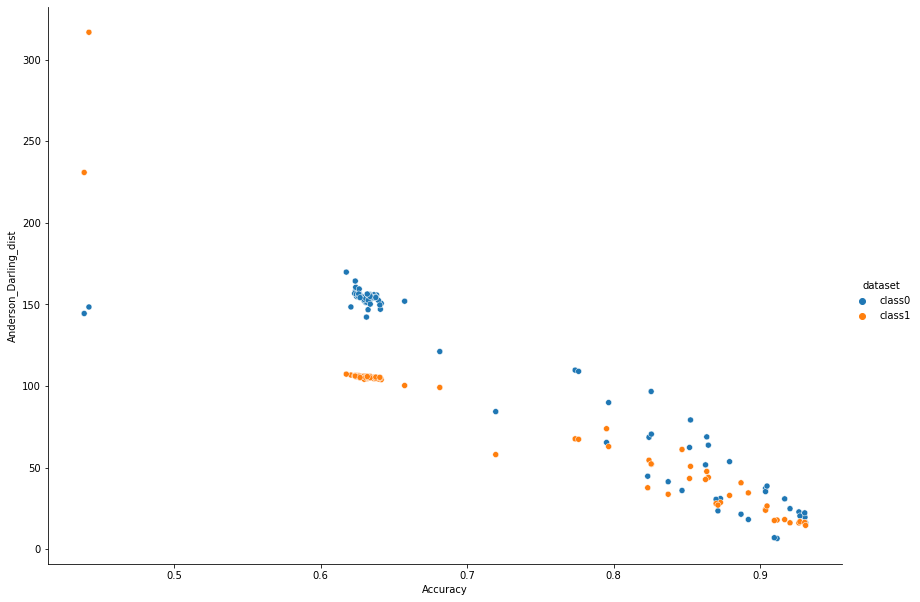

In [47]:
sns.relplot(data=concatenated, x='Accuracy', y='Anderson_Darling_dist',
                hue='dataset', height=8.27, aspect=11.7/8.27)

### Seaborn pairplot
A Seaborn **'pairplot'** can be used to plot 1 continuous feature against another, as a scatterplot in the example below.

The **data=x** parameter is where the Pandas Dataframe (results) is to be passed. Seaborn only allows 1 Pandas Dataframe to be passed in. This is where it can differ from Matplotlib. Seaborn can use this Dataframe **x**, and it can pull out column names, etc... automatically for you. Thus, instead of writing **'y_vars=concatenated['Accuracy']'**, which is what one would usually have to do, you can just write the column name, and Seaborn will find this in via the **data=x** provided.

The **y_vars=x[y]** parameter defines what column's data will be used on the y-axis. The column/ feature name, **y**, provided via **x[y]** is the column that will be used in the plot.

The **x_vars=x[x1, x2, x3, ...]** parameter defines what column or columns' data will be used on the x-axis. Since a pairplot is built specific to plot 'pairs' of columns against each other, an array can be passed into this. Each new array index will add an extra plot (horizontally) to the pair plot.

The **hue** parameter describes which feature/ column will be used to differentiate between data points plotted. It's like a **legend** or **c** parameter in Matplotlib. See here for in-depth explanation, comparing Matplotlib and Seaborn: https://stackoverflow.com/a/26139658

The **height** and **aspect** parameters are used to define the size of the plots. Height for the individual plot height, and aspect to control the width of each plot.

See docs: https://seaborn.pydata.org/generated/seaborn.pairplot.html

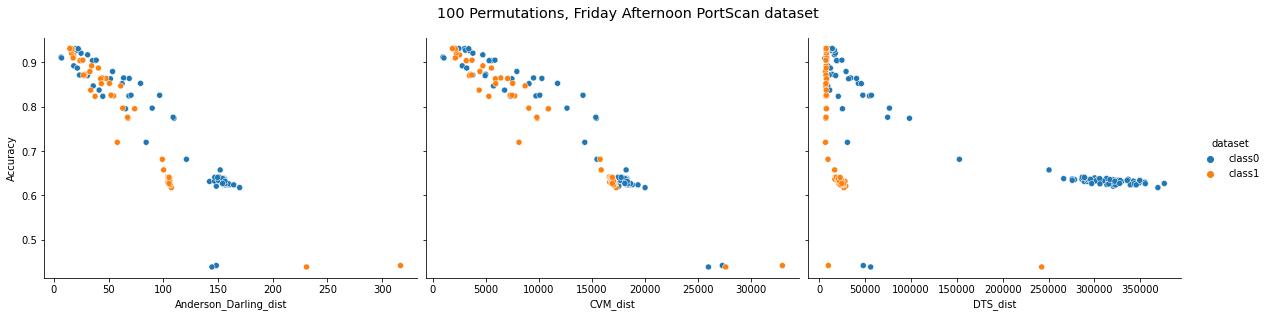

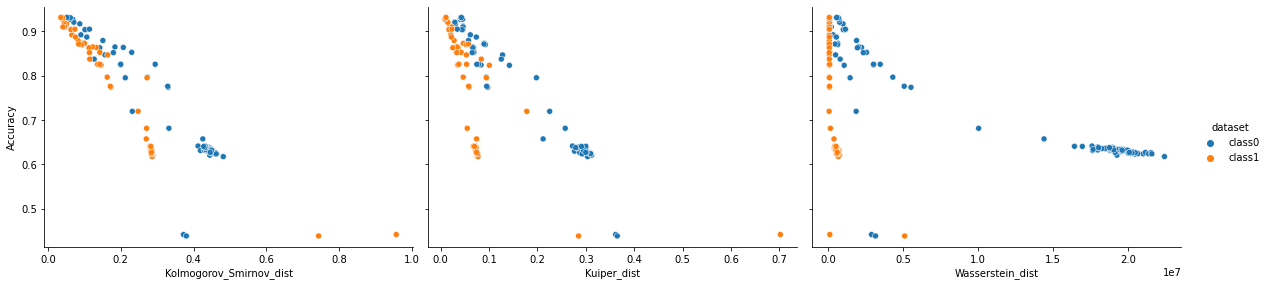

In [56]:
plot_title = "100 Permutations, Friday Afternoon PortScan dataset"

g = sns.pairplot(
    data=concatenated,
    y_vars=['Accuracy'],
    x_vars=['Anderson_Darling_dist', 'CVM_dist','DTS_dist'],
    hue='dataset',
    height=4,
    aspect=1.4
)
g.fig.suptitle(plot_title, y=1.08, fontsize='x-large')

sns.pairplot(
    data=concatenated,
    y_vars=['Accuracy'],
    x_vars=['Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist'],
    hue='dataset',
    height=4,
    aspect=1.4
)

### Seaborn lineplot

A Seaborn lineplot is just a normal lineplot graph, where the x and y axis can be defined, and a hue for colouring and differentiating each class can be defined on a column.

The **markers=True** parameter defines an "Object determining how to draw the markers for different levels of the style variable. Setting to True will use default markers" (Seaborn docs).

The **dashes=False** parameter just prevents dashing lines being used, which can make the plot less pleasing-to-the-eye.

The **err_style="bars"** parameter defines that the std should be shown as bars, instead of the default which can be really distracting. The **ci=40** parameter is linked to this: "Show error bars instead of error bands and plot the 68% confidence interval (standard error)" (Seaborn docs).

The **estimator="mean"** parameter just denotes that each point should plot the mean value, if multiple points lie on the exact same x-axis level i.e. 2 points with exactly 98.8687% accuracy for example. The distance of these 2 points will be used to calculate a mean value, and this mean value will be plotted.

See docs here: https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot

The **plt.figure(figsize=(14,8))** just defines the plot/ graph size, in inches on the screen. (14, 8) is 14 inch width and 8 inch height. Used in Matplotlib, see: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

### What do the below graphs show?

**All the lineplots below show the accuracy plotted against each ECDF-based statistical distance measure, where each data point is 1 permutation**

<AxesSubplot:xlabel='Accuracy', ylabel='Anderson_Darling_dist'>

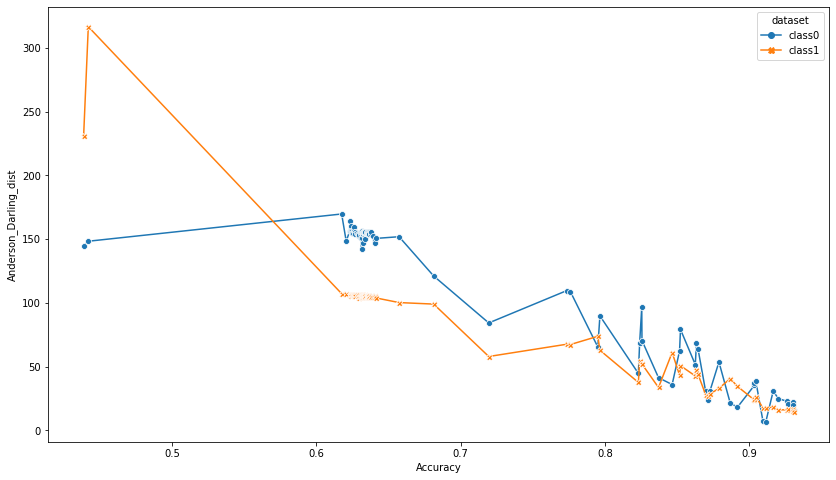

In [49]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Anderson_Darling_dist', hue="dataset", style="dataset",
    markers=True, dashes=False, err_style="bars", ci=40, estimator="mean")

<AxesSubplot:xlabel='Accuracy', ylabel='CVM_dist'>

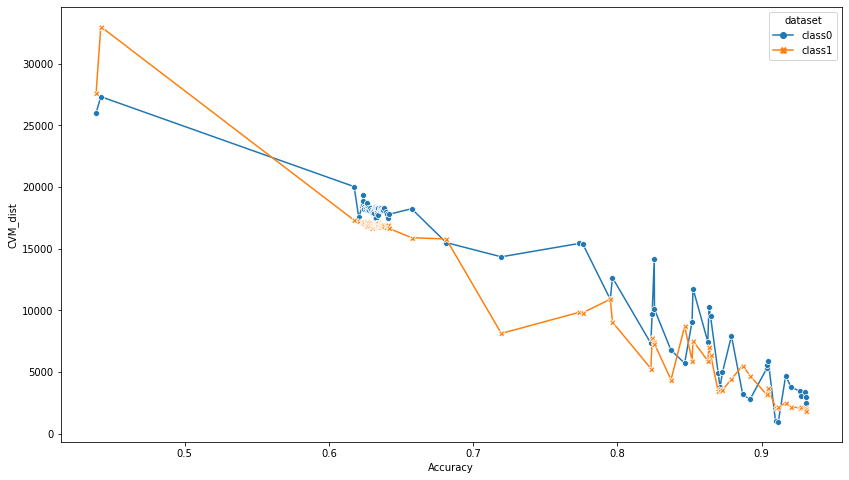

In [50]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='CVM_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<AxesSubplot:xlabel='Accuracy', ylabel='DTS_dist'>

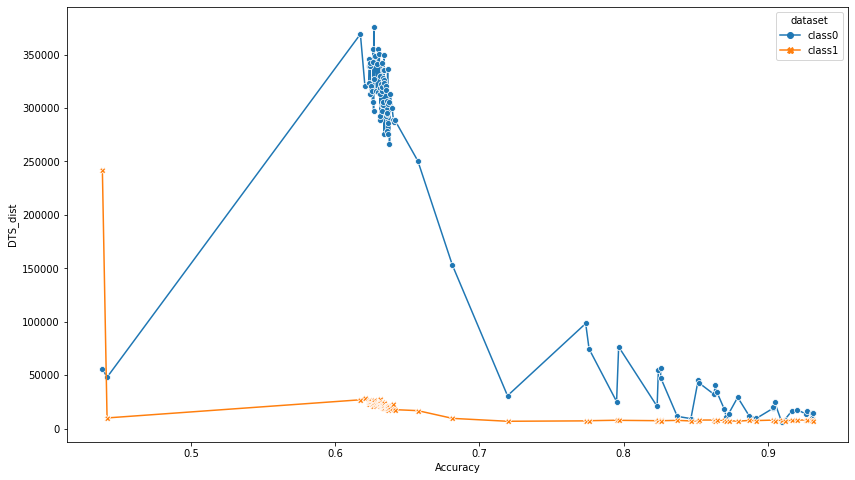

In [51]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='DTS_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<AxesSubplot:xlabel='Accuracy', ylabel='Kolmogorov_Smirnov_dist'>

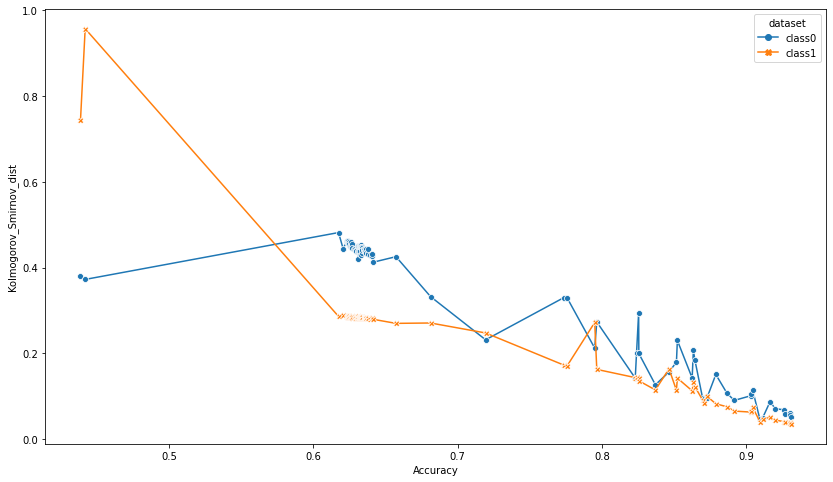

In [52]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Kolmogorov_Smirnov_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<AxesSubplot:xlabel='Accuracy', ylabel='Kuiper_dist'>

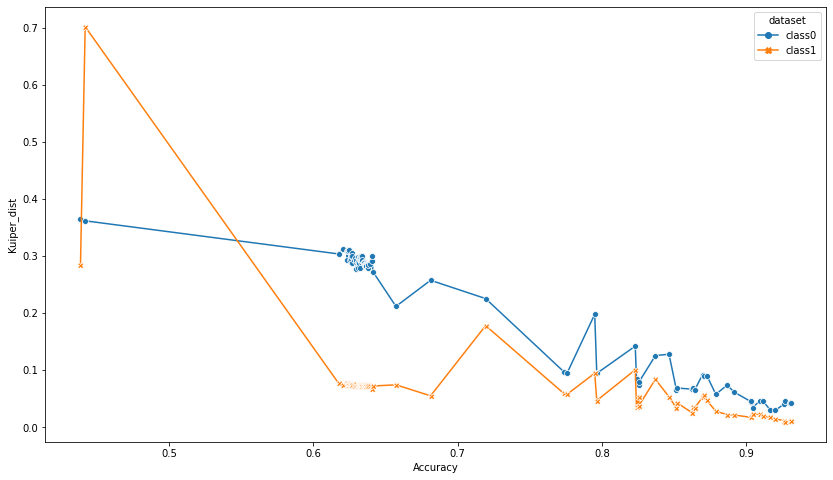

In [53]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Kuiper_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<AxesSubplot:xlabel='Accuracy', ylabel='Wasserstein_dist'>

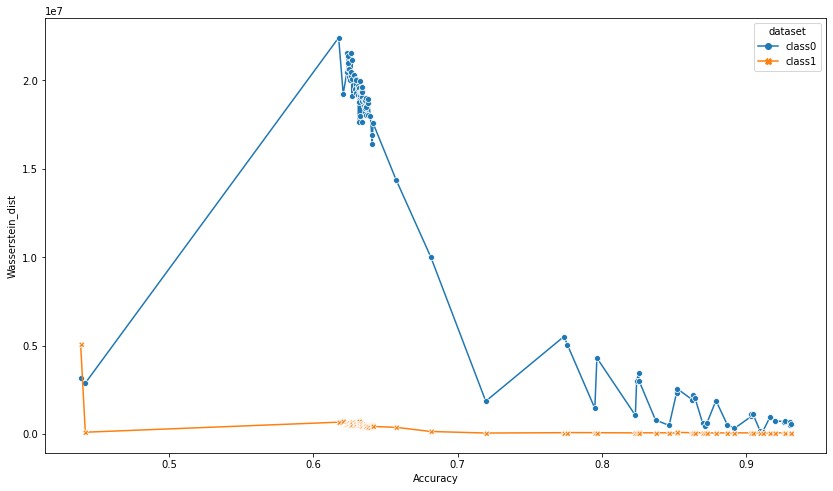

In [54]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Wasserstein_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

Boxplot to show the variance in Anderson_darling distance between each class in the dataset. Just an example of what could be plotted further.

Mean Accuracy (Mu) = 70.79779793425261 %


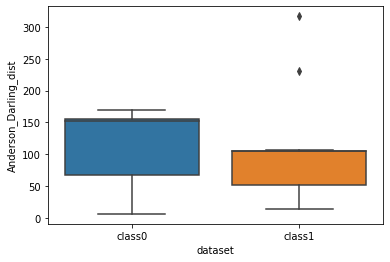

In [55]:
sns.boxplot(data=concatenated, x='dataset', y='Anderson_Darling_dist')

accuracies = concatenated['Accuracy']
mean_accuracy = accuracies[concatenated['dataset'] == 'class0'].mean()
print('Mean Accuracy (Mu) =', mean_accuracy*100, '%')

**May add feature-importance plotting here, for future SafeML Python package to be made...**